In [113]:
import cosmoboost as cb
import matplotlib.pyplot as plt
#cb.cosmoboost.COSMOBOOST_DIR
import healpy as hp
import numpy as np
from scipy.ndimage import gaussian_filter as GF
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.size']=16
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Temperature Only

In [82]:
#read the default parameters from cosmoboost
pars = cb.DEFAULT_PARS

#change the paremeters to custome values
pars['lmax']=lmax=1000
pars['delta_ell']=10
pars['d']=1
pars['beta_exp_order']=6
pars['normalized']=False
pars['beta']=beta=0.01
T_0 = pars["T_0"]



In [83]:
#print all the parameters

pars

{'d': 1,
 's': 0,
 'beta': 0.01,
 'lmin': 0,
 'lmax': 1000,
 'delta_ell': 10,
 'T_0': 2.72548,
 'beta_expansion_order': 4,
 'derivative_dnu': 1.0,
 'normalize': True,
 'frequency_function': 'CMB',
 'beta_exp_order': 6,
 'normalized': False}

In [84]:
# initialize the kernel 
kernel = cb.Kernel(pars)

Calculating the index matrices...


initializing fits file for the matrices...



INFO:lib.KernelODE:rtol = 0.001


Matrices saved in file:
/Users/siavashyasini/Dropbox/Cosmology/Projects/2019/CosmoBoost/cosmoboost/kernel/beta_0.01/lmax_1000/M_T_s_0_delta_10_lmax_1000_beta_0.01.fits

Done!

Solving kernel ODE for d=1
calculating the Doppler and aberration Kernel elements started at 17:53:03 PM

beta (v/c) :  0.01
eta (arctanh(beta) :  0.010000333353334763


/Users/siavashyasini/anaconda/envs/py36/lib/python3.6/site-packages/scipy/integrate/odepack.py:250: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)



calculating the Doppler and aberration Kernel elements was done in 0.8 min.

dirname = /Users/siavashyasini/Dropbox/Cosmology/Projects/2019/CosmoBoost/cosmoboost/kernel/beta_0.01/lmax_1000

initializing fits file for the kernel...

Kernel saved in:
/Users/siavashyasini/Dropbox/Cosmology/Projects/2019/CosmoBoost/cosmoboost/kernel/beta_0.01/lmax_1000/K_T_s_0_delta_10_lmax_1000_beta_0.01.fits


In [85]:
def plot_mlpL_slices(kernel,m,lp,):
# Initialize the generalized kernel at 217 GHz
    K_mlpL = kernel.mlpl[cb.mh.mlp2indx(m,lp,lmax)]
    
    L = np.arange(-kernel.delta_ell,kernel.delta_ell+1)
    
    plt.figure(figsize=(10,5))


    plt.semilogy(L,np.abs(K_mlpL),'k')
    plt.semilogy(L,np.abs(K_nu_mlpL),'ro')
    plt.xlabel(r"$\Delta \ell$")
    plt.ylabel(r"$|K_{m,\ell',\ell}|$")

    plt.show()

#kernel_nu = np.abs(kernel.nu_mlpl(217));

In [89]:
# print the a slice of the K_{m, lp, l} and K_nu_{m, lp, l} matrices

m=10
lp = 100
nu_0 =500 
K_mlpL = kernel.mlpl[cb.mh.mlp2indx(m,lp,lmax)]
K_nu_mlpL = kernel.nu_mlpl(nu_0)[cb.mh.mlp2indx(m,lp,lmax)]#/cb.ff.F_nu(nu,T_0)

print("K_mlpl = {}".format(K_mlpL))


INFO:lib.KernelRecursive:d, i = 1,1
INFO:lib.KernelRecursive:d, i = 1,0
INFO:lib.KernelRecursive:loading key 0d2
INFO:lib.KernelRecursive:loading key 0d2
INFO:lib.KernelRecursive:d, i = 1,-1
INFO:lib.KernelRecursive:loading key 0d3
INFO:lib.KernelRecursive:loading key 0d3
INFO:lib.KernelRecursive:d, i = 1,-2
INFO:lib.KernelRecursive:loading key 0d4
INFO:lib.KernelRecursive:loading key 0d4
INFO:lib.KernelRecursive:d, i = 1,-3
INFO:lib.KernelRecursive:loading key 0d5
INFO:lib.KernelRecursive:loading key 0d5
INFO:lib.KernelRecursive:d, i = 1,-4
INFO:lib.KernelRecursive:loading key 0d6
INFO:lib.KernelRecursive:loading key 0d6
INFO:lib.KernelRecursive:d, i = 1,-5
INFO:lib.KernelRecursive:loading key 0d7
INFO:lib.KernelRecursive:loading key 0d7


Kernel elements are normalized

K_mlpl = [ 1.5678e-10  3.4585e-09  6.7876e-08  1.1704e-06  1.7451e-05  2.2032e-04
  2.2879e-03  1.8728e-02  1.1281e-01  4.3843e-01  7.6517e-01 -4.4170e-01
  1.1703e-01 -2.0423e-02  2.6762e-03 -2.8208e-04  2.4955e-05 -1.9074e-06
  1.2865e-07 -7.7792e-09  4.2806e-10]


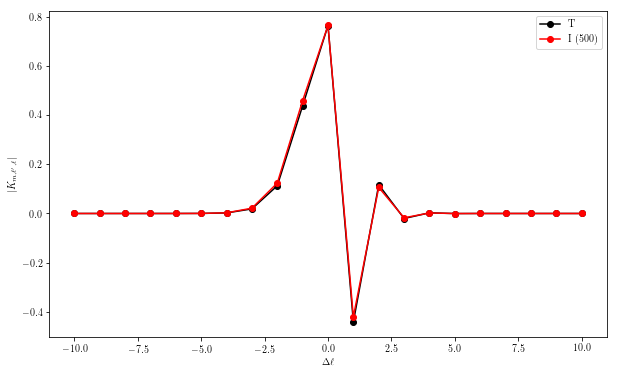

In [91]:
L = np.arange(-kernel.delta_ell,kernel.delta_ell+1)
plt.figure(figsize=(10,6))


plt.plot(L,(K_mlpL),'k-o',label='T')
plt.plot(L,(K_nu_mlpL),'r-o',label=f"I ({nu_0})")
plt.xlabel(r"$\Delta \ell$")
plt.ylabel(r"$|K_{m,\ell',\ell}|$")

plt.legend()
plt.show()

# Simulate the sky

In [92]:
import healpy as hp 
import numpy as np

Dl = np.load("cosmoboost/lib/CAMB_Cl_H0=67.74,ombh2=0.022,omch2=0.1188,mnu=0.06,tau=0.066,As=2.3e-9,ns=0.9667.npy")

T_0 = 2.725
L=np.arange(lmax+1)
rescale = T_0**2*(2*np.pi) / (L*(L+1)) #conversion factor from Dl to Cl
rescale[0]=0. #fix the ell=0 mode from inf to 0

Dl_TT=Dl[:lmax+1,0]
Dl_EE=Dl[:lmax+1,1]
Dl_BB=Dl[:lmax+1,2]
Dl_TE=Dl[:lmax+1,3]

Cl_TT = rescale*Dl_TT
Cl_EE = rescale*Dl_EE
Cl_BB = rescale*Dl_BB
Cl_TE = rescale*Dl_TE


Cl = np.array([Cl_TT,Cl_EE,Cl_BB,Cl_TE])
alm_T, alm_E, alm_B = hp.synalm(Cl,lmax=lmax,new=True,verbose=True)

alm_r = np.array([alm_T, alm_E, alm_B])

Cl_r = hp.alm2cl(alm_r)

In [93]:
# plot the power spectra in the rest frame

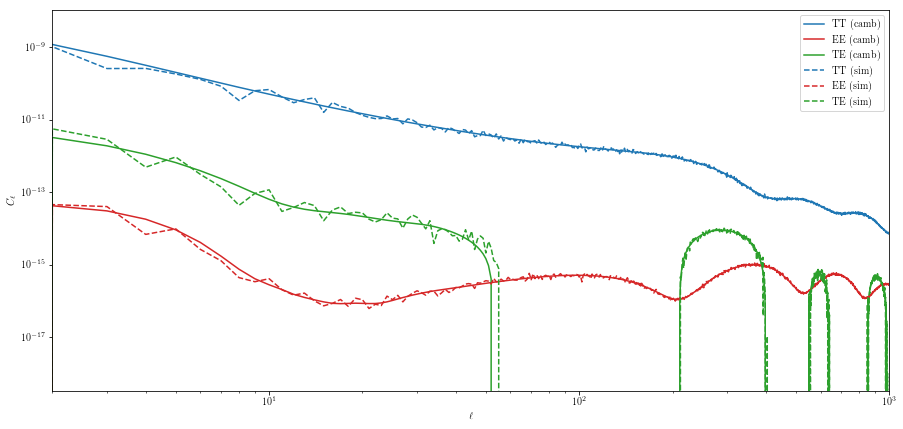

In [94]:
plt.figure(figsize=(15,7))
plt.plot(L,Cl_TT, label="TT (camb)",color='tab:blue')
plt.plot(L,Cl_EE, label="EE (camb)",color='tab:red')
plt.plot(L,Cl_TE, label="TE (camb)",color='tab:green')

plt.plot(L,Cl_r[0],label="TT (sim)",color='tab:blue',linestyle='--')
plt.plot(L,Cl_r[1],label="EE (sim)",color='tab:red',linestyle='--')
plt.plot(L,Cl_r[3],label="TE (sim)",color='tab:green',linestyle='--')
#plt.plot(L,Cl_sim[3])
#plt.plot(L,Cl_sim[4])
#plt.plot(L,Cl_sim[5])

plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")

plt.xscale("log")
plt.yscale("log")

plt.legend(loc="upper right")
plt.xlim(2,lmax)
plt.show()

# Boost the Sky

In [95]:
# boost the alm
alm_T_r = alm_T
alm_T_b = cb.boost_alm(alm_T_r,kernel)
#alm_T_boos_217 = cb.deboost_alm(alm_T[None,:],kernel,217)

INFO:cosmoboost.cosmoboost:boosting T_lm


adding new axis to the input alm...

boosting T
Done!


In [96]:
# calculate the tempreture power spectrum in the boosted frame
Cl_T_r = Cl_r[0]
Cl_T_b = hp.alm2cl(alm_T_b)
Cl_T_b_kernel = cb.boost_Cl(Cl_r[0],kernel)
Cl_T_b_jeong = cb.jeong_boost_Cl(L, Cl_TT, beta)

using <cos> = 7.25758002000911e-16
using <cos2> = 0.33333333333333337


In [109]:
Cl_I_b_kernel = cb.boost_Cl(Cl_r[0],kernel, 217)

INFO:lib.KernelRecursive:d, i = 1,1
INFO:lib.KernelRecursive:d, i = 1,0
INFO:lib.KernelRecursive:loading key 0d2
INFO:lib.KernelRecursive:loading key 0d2
INFO:lib.KernelRecursive:d, i = 1,-1
INFO:lib.KernelRecursive:loading key 0d3
INFO:lib.KernelRecursive:loading key 0d3
INFO:lib.KernelRecursive:d, i = 1,-2
INFO:lib.KernelRecursive:loading key 0d4
INFO:lib.KernelRecursive:loading key 0d4
INFO:lib.KernelRecursive:d, i = 1,-3
INFO:lib.KernelRecursive:loading key 0d5
INFO:lib.KernelRecursive:loading key 0d5
INFO:lib.KernelRecursive:d, i = 1,-4
INFO:lib.KernelRecursive:loading key 0d6
INFO:lib.KernelRecursive:loading key 0d6
INFO:lib.KernelRecursive:d, i = 1,-5
INFO:lib.KernelRecursive:loading key 0d7
INFO:lib.KernelRecursive:loading key 0d7


Kernel elements are normalized



In [97]:
dL = 5

dCl_T_b = (Cl_T_b - Cl_T_r)
dCl_Cl_T_b = dCl_T_b/Cl_T_r
dCl_Cl_T_b_GF = GF(dCl_Cl_T_b,dL)

dCl_T_b_kernel = (Cl_T_b_kernel - Cl_T_r)
dCl_Cl_T_b_kernel = dCl_T_b_kernel/Cl_T_r
dCl_Cl_T_b_kernel_GF = GF(dCl_Cl_T_b_kernel,dL)

dCl_T_b_jeong = (Cl_T_b_jeong - Cl_TT)
dCl_Cl_T_b_jeong = dCl_T_b_jeong/Cl_TT
dCl_Cl_T_b_jeong_GF = GF(dCl_Cl_T_b_jeong,dL)

/Users/siavashyasini/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['stix'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


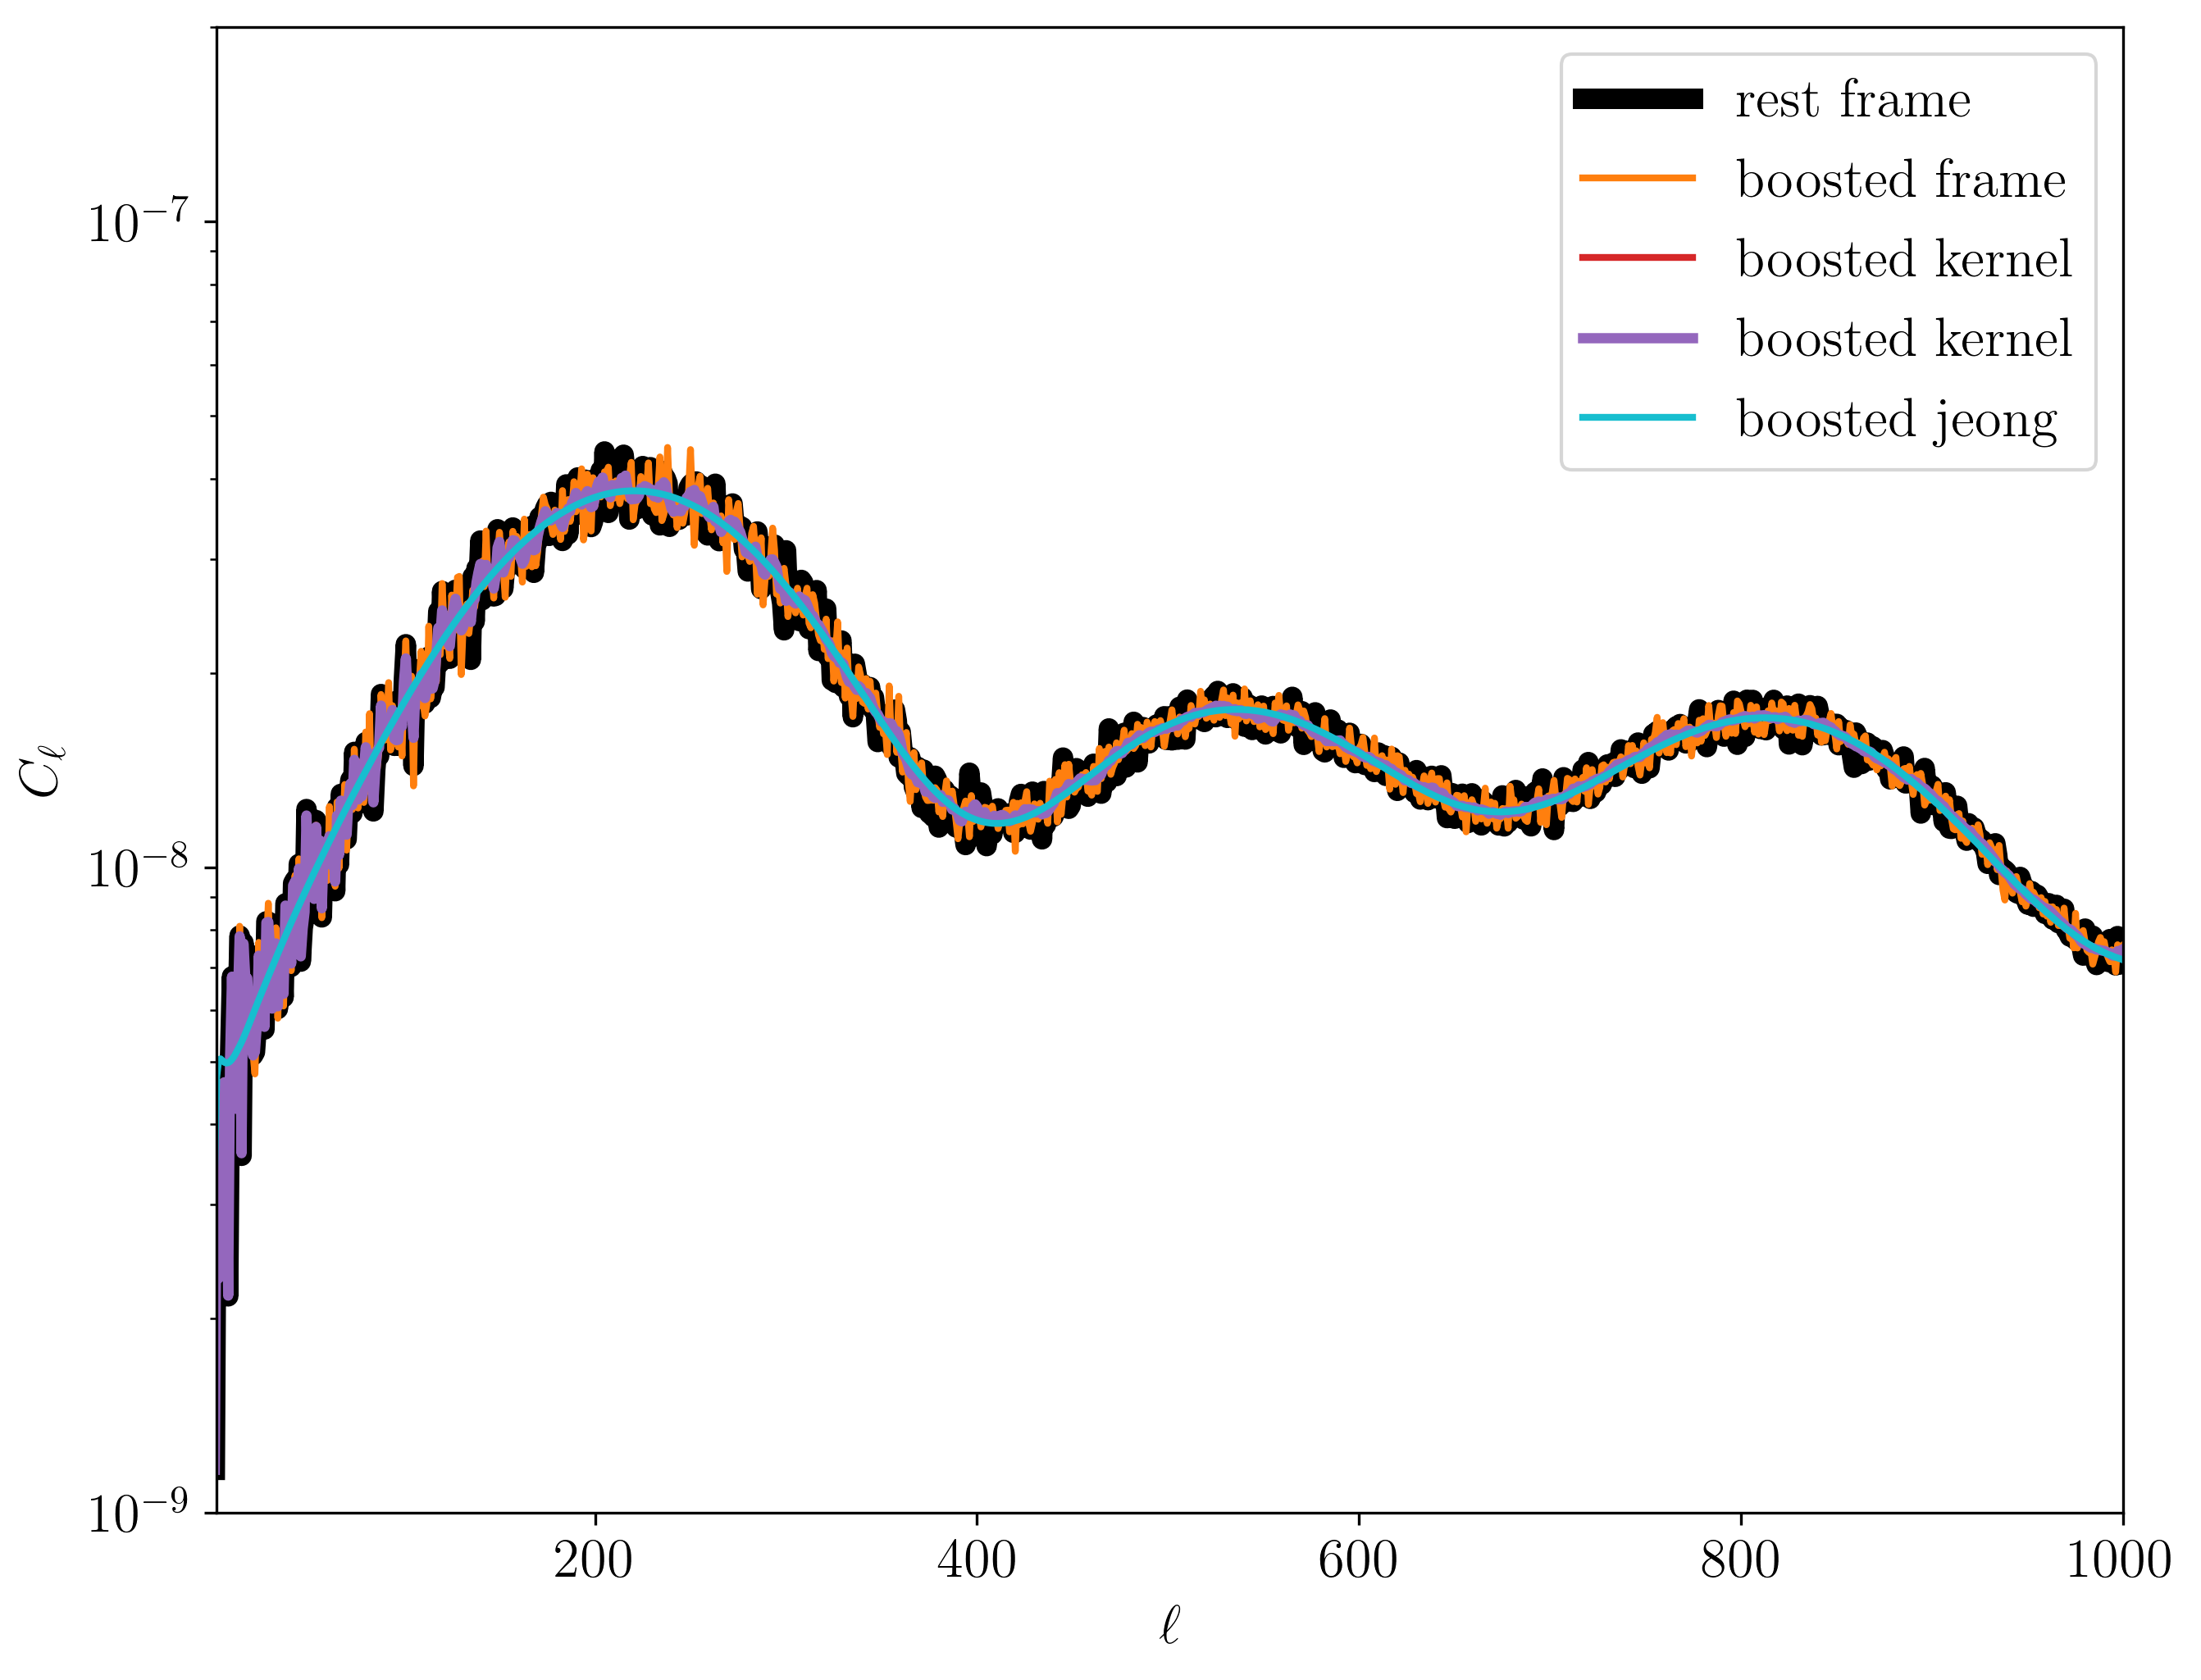

In [114]:
plt.figure(figsize=(10,8,),dpi=150)
plt.plot(L,L**2*Cl_T_r,linewidth=6,color='k',label='rest frame')
plt.plot(L,L**2*Cl_T_b,linewidth=2,color="tab:orange",label='boosted frame')
plt.plot(L,L**2*Cl_T_b_kernel,linewidth=2,color="tab:red",label='boosted kernel')
plt.plot(L,L**2*Cl_I_b_kernel,linewidth=3,color="tab:purple",label='boosted kernel')
plt.plot(L,L**2*Cl_T_b_jeong,linewidth=2,color="tab:cyan",label='boosted jeong')

plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")

#plt.xscale("log")
plt.yscale("log")
plt.xlim(2,lmax)
plt.ylim(1E-9,2E-7)
plt.legend()

plt.show()

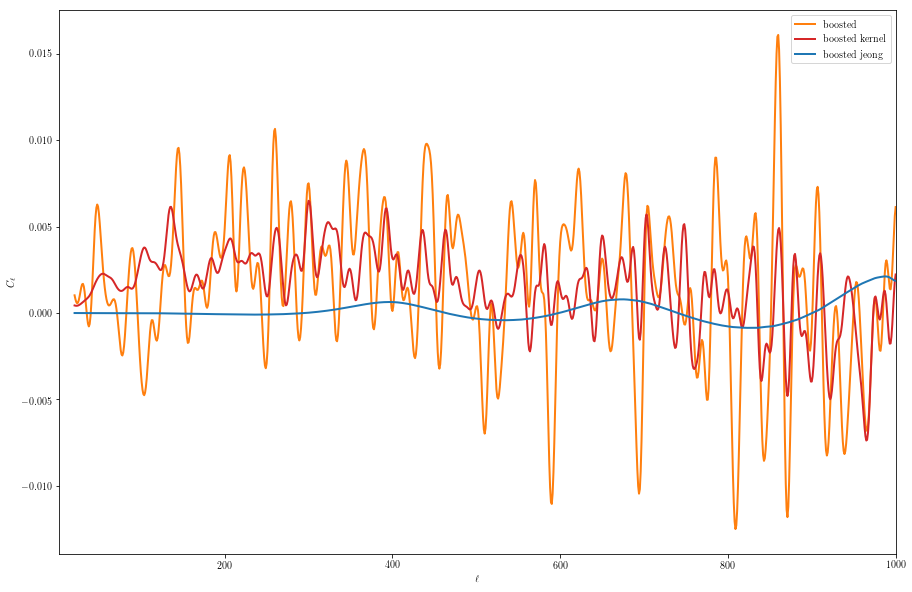

In [99]:
plt.figure(figsize=(15,10,))

plt.plot(dCl_Cl_T_b_GF,linewidth=2,color="tab:orange",label='boosted')
plt.plot(dCl_Cl_T_b_kernel_GF,linewidth=2,color="tab:red",label='boosted kernel')
plt.plot(dCl_Cl_T_b_jeong_GF,linewidth=2,color="tab:blue",label='boosted jeong')

plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")

#plt.xscale("log")
#plt.yscale("log")
plt.xlim(2,lmax)
#plt.ylim(1E-14,2E-8)
plt.legend()

plt.show()

# Mask The sky

In [100]:
def tophalfcut_mask(cut_angle, lat_pix):
    mask = np.zeros(len(lat_pix))
    mask[(lat_pix < cut_angle)] = 1.

    f_sky = len(mask[mask == 0.]) / len(mask)

    return mask, f_sky

In [101]:
NSIDE=1024
NPIX = hp.nside2npix(NSIDE)
lon_pix, lat_pix = hp.pix2ang(NSIDE,np.arange(NPIX),lonlat=True)

In [102]:
mask_45,f_sky = tophalfcut_mask(45,lat_pix)

In [103]:
T_map_r = hp.alm2map(alm_T_r,NSIDE)
T_map_b = hp.alm2map(alm_T_b,NSIDE)

T_map_r_ma = hp.ma(T_map_r);
print(T_map_r_ma.shape)
T_map_r_ma.mask = mask_45

T_map_b_ma = hp.ma(T_map_b);
print(T_map_b_ma.shape)
T_map_b_ma.mask = mask_45

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(12582912,)
(12582912,)


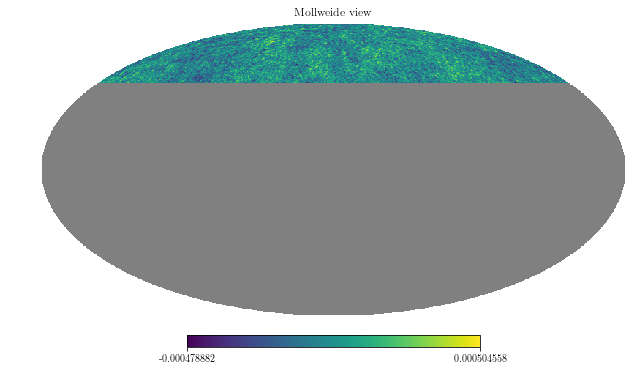

In [104]:
hp.mollview(T_map_r_ma)


In [105]:
Cl_T_r_ma =(1/f_sky)*hp.anafast(T_map_r_ma,lmax=lmax)

Cl_T_b_ma =(1/f_sky)*hp.anafast(T_map_b_ma,lmax=lmax)


In [106]:
dCl_Cl = (Cl_T_r_ma/Cl_T_b_ma)-1

from scipy.ndimage import gaussian_filter as GF
dCl_Cl_GF = GF(dCl_Cl,20)

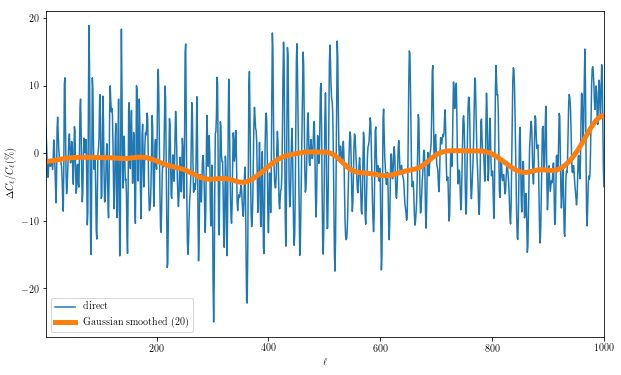

In [107]:
plt.figure(figsize=(10,6))
plt.plot(L,100*(dCl_Cl),label="direct")
plt.plot(L,100*(dCl_Cl_GF),linewidth=5,label="Gaussian smoothed (20)")

plt.xlabel("$\ell$")
plt.ylabel("$\Delta C_\ell/C_\ell (\%)$")

plt.legend()
plt.xlim(2,lmax)
plt.show()